In [27]:
import cv2
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt

from pca import PCA
from linear_classifier import LinearClassifier


In [28]:
# Variaveis globais usadas para desenhar com o mouse
drawing = False
number_image = np.zeros((500, 500), dtype=np.uint8)

# Função para desenhar com o mouse
def draw_number(event, x, y, flags, param):
    global drawing, number_image

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        cv2.circle(number_image, (x, y), 10, (255), -1)
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.circle(number_image, (x, y), 10, (255), -1)
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False

In [29]:
# função para carregar os dados
def load_data(train_path_images, train_path_labels, test_path_images, test_path_labels):
    X_train = idx2numpy.convert_from_file(train_path_images)
    Y_train = idx2numpy.convert_from_file(train_path_labels)

    X_test = idx2numpy.convert_from_file(test_path_images)
    Y_test = idx2numpy.convert_from_file(test_path_labels)

    y_train = Y_train.astype(int)
    y_test = Y_test.astype(int)
    
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    return X_train, y_train, X_test, y_test

In [30]:
# Função principal, aplica o classificador linear com ou sem o pca
def main():
    epochs = 100
    pca_apply = False
    pca_percentage_var = 0.8
    learning_rate = 0.95
    
    train_path_images = 'dataset/train/train-images.idx3-ubyte'
    train_path_labels = 'dataset/train/train-labels.idx1-ubyte'

    test_path_images = 'dataset/test/t10k-images.idx3-ubyte'
    test_path_labels = 'dataset/test/t10k-labels.idx1-ubyte'
    
    X_train, Y_train, X_test, Y_test = load_data(train_path_images, train_path_labels, test_path_images, test_path_labels)

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    num_classes = len(np.unique(Y_train))
    
    if pca_apply:
        pca = PCA(percentage_var=pca_percentage_var)
        X_train = pca.pca(X_train)
        X_test = pca.transform(X_test)
    
    linear_classifier_model = LinearClassifier()
    linear_classifier_model.fit(X_train, Y_train, num_classes)
    predictions = linear_classifier_model.predict(X_test)
    
    # accuracy = np.mean(predictions == Y_test)
    # print(f'Acurácia do Classificador Linear de Mínimos Quadrados: {accuracy:.4f}')
    # print(f'Taxa de erro: {1 - accuracy:.4f}')


    # Create a window for drawing
    cv2.namedWindow("Desenhe um digito")
    cv2.setMouseCallback("Desenhe um digito", draw_number)

    global number_image
    while True:
        cv2.imshow("Desenhe um digito", number_image)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):  # Pressione 'q' para sair
            break
        elif key == ord("c"):  # Pressione 'c' para limpar o desenho
            number_image = np.zeros((500, 500), dtype=np.uint8)
        elif key == ord("p"):  # Pressione 'p' para aplicar o modelo de classificação linear
            number_label = str(input('Digite o rotulo do numero:'))
            drawn_number = cv2.resize(number_image, (28, 28))  # dimensao 28x28
            drawn_number = cv2.bilateralFilter(drawn_number, -1, 5, 5)
            
            drawn_number = drawn_number.reshape(drawn_number.shape[0], -1)
            
            drawn_number[drawn_number !=0] = 255

            if pca_apply:
                drawn_number = pca.transform(drawn_number)
                
            prediction = linear_classifier_model.predict_real_time(np.array(drawn_number))
            # Mostrando o numero inserido e o numero predito pelo modelo
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(drawn_number.reshape(28, 28), cmap='gray')
            plt.title('Número Desenhado')
            plt.axis('off')
            plt.subplot(1, 2, 2)
            # Plotar o valor predito como texto
            if str(number_label) == str(prediction[0]):
                plt.text(0.5, 0.5, str(prediction[0]), c='green', fontsize=250, ha='center', va='center')
            else:
                plt.text(0.5, 0.5, str(prediction[0]), c='red', fontsize=250, ha='center', va='center')
            plt.title('Resultado dado pelo modelo de classificação linear')
            plt.axis('off')
            plt.tight_layout()
            plt.show()
            
    cv2.destroyAllWindows()
    

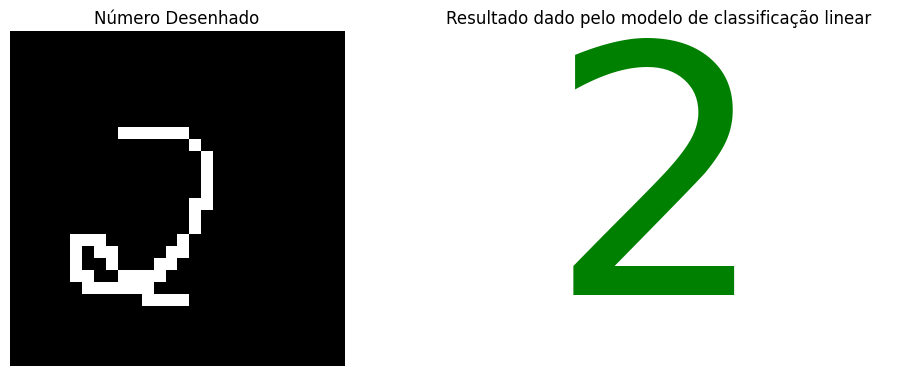

In [31]:
# chamando a função principal
main()